In [162]:
dfCrime = read.csv("crime_v2.csv")
# install.packages("dplyr")
install.packages("stargazer")
#library(survey)
library(effsize)
library(dplyr)
library(ggplot2)
library('corrplot')
#library(tableone)
#conda install -c conda-forge tableone

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [163]:
#summary(dfCrime)

In [164]:
#unique(dfCrime$prbconv)

In [165]:
# dfCrime[is.na(dfCrime),]
# dfCrime
nrow(dfCrime)

[1] 97

In [166]:
dfCrime <-na.omit(dfCrime) # get rid of the NA rows
nrow(dfCrime)

[1] 91

In [167]:
dfCrime[duplicated(dfCrime),]
# unique(dfCrime$county)

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
89,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,⋯,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.1105016,0.07819394


In [168]:
dfCrime <- dfCrime[!duplicated(dfCrime),] # get rid of the duplicated row
nrow(dfCrime)

[1] 90

In [169]:
dfCrime$prbconv<-as.numeric(levels(dfCrime$prbconv))[dfCrime$prbconv]
#dfCrime$prbconv<-as.double(dfCrime$prbconv)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [170]:
dfCrime$county<-as.factor(dfCrime$county) #note that we're missing 10 counties from NC; 6 were blank rows in this set, one row was a duplicate

In [171]:
dfCrime$pctmin80<-dfCrime$pctmin80/100 # units are off in comparison to pctymle; we either divide by 100 here or multiply the other one

In [172]:
#Map central and west to a region code.
# Note that county 71 has both western and central codes
dfCrime$region <- case_when (
            (dfCrime$central ==0 & dfCrime$west ==0) ~ 0, #Eastern, Coastal, Other
            (dfCrime$central ==0 & dfCrime$west ==1) ~ 1, #Western
            (dfCrime$central ==1 & dfCrime$west ==0) ~ 2, #Central
            (dfCrime$central ==1 & dfCrime$west ==1) ~ 3, #Central-Western border county - this could be Charlotte or it could be a coding error.
        )

In [173]:
# create a factor for 'central', 'western', 'central/western' and 'eastern, coastal, other' region
dfCrime$region =
            factor( dfCrime$region , levels = 0:3 , labels =
                    c( 'Region 1',
                       'Region 2',
                       'Region 3',
                       'Region 4'
                      )
                   )

In [195]:
# create factor for SMSA (standard metropolitan statistical areas) with two levels - inside or outside
#    https://www2.census.gov/prod2/decennial/documents/1980/1980censusofpopu8011uns_bw.pdf
dfCrime$metro =
            factor( dfCrime$urban , levels = 0:1 , labels =
                    c( 'Outside',
                       'Inside'
                      )
                   )

In [203]:
dfCrime$wage <-  dfCrime$wcon + dfCrime$wtuc + dfCrime$wtrd + dfCrime$wfir + dfCrime$wser + dfCrime$wmfg + dfCrime$wfed + dfCrime$wsta + dfCrime$wloc

summary(dfCrime$wage)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2338    2713    2906    2940    3069    3975 

In [183]:
# Need to remove rows with probability of arrest and conviction > 1
dfCrime = dfCrime[dfCrime['prbarr'] < 1,]
dfCrime = dfCrime[dfCrime['prbconv'] < 1,]

In [207]:
dfCrime$prbcrmjustice <- dfCrime$prbconv * dfCrime$prbarr
# dfCrime$logprbcrmjustice <- log10(dfCrime$logprbcrmjustice)

summary(dfCrime$prbcrmjustice)
head(dfCrime[order(-dfCrime$prbcrmjustice),])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03587 0.08432 0.11956 0.13045 0.15963 0.34146 

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,mix,pctymle,region,metro,prbcrmjustice,logcrmrte,logprbconv,logprbarr,logprbcrmjustice,wage
58,131,87,0.0189848,0.689024,0.495575,0.401786,9.97,0.00121549,0.4126394,37.70006,⋯,0.16725978,0.08356434,Region 1,Outside,0.3414631,-1.721594,-0.30489060,-0.1617657,-0.4666563,2644.494
8,15,87,0.0202814,0.392111,0.769231,0.507692,10.64,0.00103525,0.3009986,34.00304,⋯,0.23495702,0.07430546,Region 1,Outside,0.3016239,-1.692902,-0.11394321,-0.4065910,-0.5205342,2687.745
18,39,87,0.0119154,0.308333,0.972973,0.291667,11.58,0.00119154,0.4623894,27.27564,⋯,0.13744076,0.06973287,Region 2,Outside,0.2999997,-1.923891,-0.01189922,-0.5109800,-0.5228792,2610.024
52,117,87,0.0268723,0.370474,0.793233,0.236967,11.83,0.00119765,0.5813449,38.81493,⋯,0.07485030,0.07632116,Region 1,Outside,0.2938722,-1.570695,-0.10059924,-0.4312423,-0.5318415,2719.372
77,169,87,0.0121033,0.343387,0.722973,0.448598,12.36,0.00109520,0.8008850,37.70785,⋯,0.13720317,0.08280677,Region 3,Outside,0.2482595,-1.917096,-0.14087793,-0.4642161,-0.6050941,3031.232
5,9,87,0.0106232,0.518219,0.476563,0.442623,8.22,0.00086018,0.5469484,28.05474,⋯,0.06008584,0.07069755,Region 2,Outside,0.2469640,-1.973745,-0.32187967,-0.2854867,-0.6073663,2759.238


In [208]:
dfCrime$logcrmrte = log10(dfCrime$crmrte)
dfCrime$logprbconv = log10(dfCrime$prbconv)
dfCrime$logprbarr = log10(dfCrime$prbarr)
dfCrime$logprbcrmjustice = log10(dfCrime$prbcrmjustice)

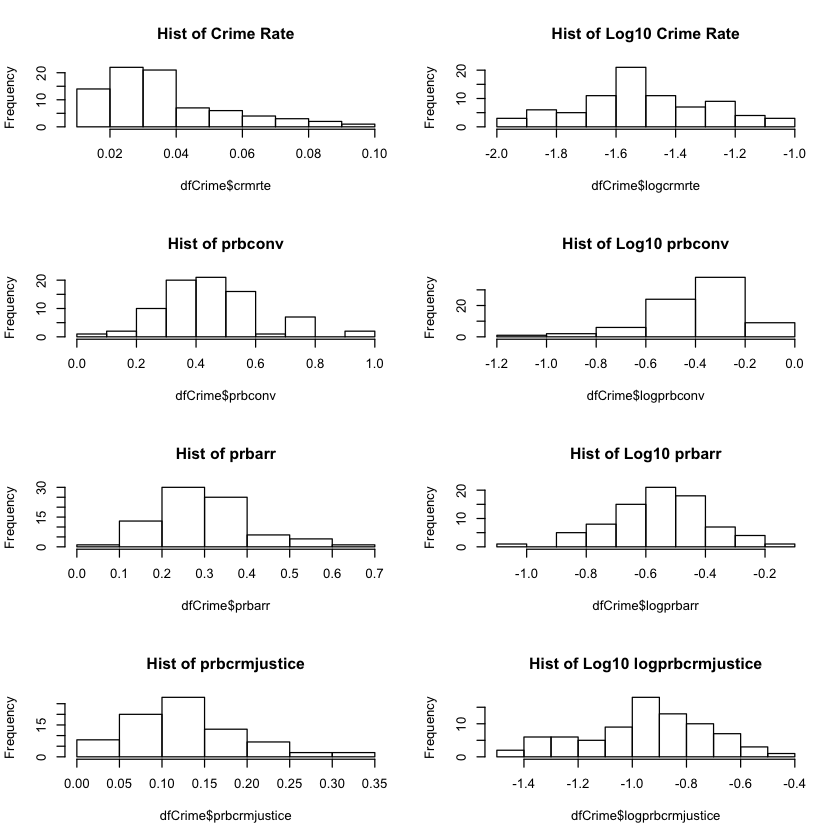

In [209]:
par(mfrow = c(4,2))
hist(dfCrime$crmrte, main="Hist of Crime Rate")
hist(dfCrime$logcrmrte, main="Hist of Log10 Crime Rate")
hist(dfCrime$prbconv, main="Hist of prbconv")
hist(dfCrime$logprbconv, main="Hist of Log10 prbconv")
hist(dfCrime$prbarr, main="Hist of prbarr")
hist(dfCrime$logprbarr, main="Hist of Log10 prbarr")
hist(dfCrime$prbcrmjustice, main="Hist of prbcrmjustice")
hist(dfCrime$logprbcrmjustice, main="Hist of Log10 logprbcrmjustice")

## model 1

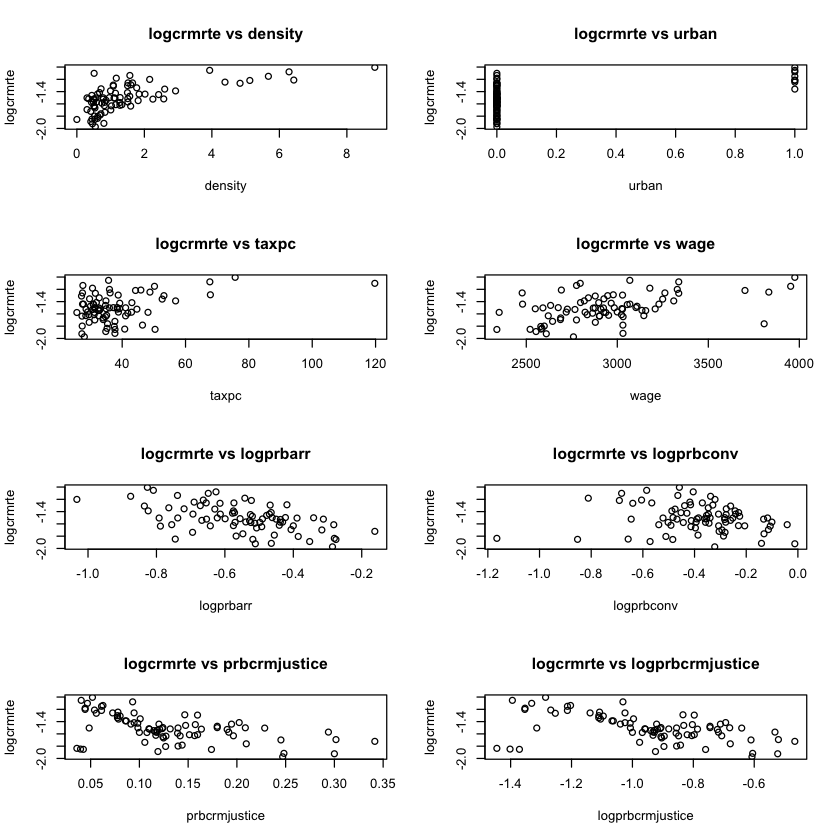

In [210]:
par(mfrow = c(4,2))
plot(dfCrime$density, dfCrime$logcrmrte, main = 'logcrmrte vs density', xlab='density', ylab='logcrmrte')

plot(dfCrime$urban, dfCrime$logcrmrte, main = 'logcrmrte vs urban', xlab='urban', ylab='logcrmrte')

plot(dfCrime$taxpc, dfCrime$logcrmrte, main = 'logcrmrte vs taxpc', xlab='taxpc', ylab='logcrmrte')

plot(dfCrime$wage, dfCrime$logcrmrte, main = 'logcrmrte vs wage', xlab='wage', ylab='logcrmrte')

plot(dfCrime$logprbarr, dfCrime$logcrmrte, main = 'logcrmrte vs logprbarr', xlab='logprbarr', ylab='logcrmrte')

plot(dfCrime$logprbconv, dfCrime$logcrmrte, main = 'logcrmrte vs logprbconv', xlab='logprbconv', ylab='logcrmrte')

plot(dfCrime$prbcrmjustice, dfCrime$logcrmrte, main = 'logcrmrte vs prbcrmjustice', xlab='prbcrmjustice', ylab='logcrmrte')

plot(dfCrime$logprbcrmjustice, dfCrime$logcrmrte, main = 'logcrmrte vs logprbcrmjustice', xlab='logprbcrmjustice', ylab='logcrmrte')


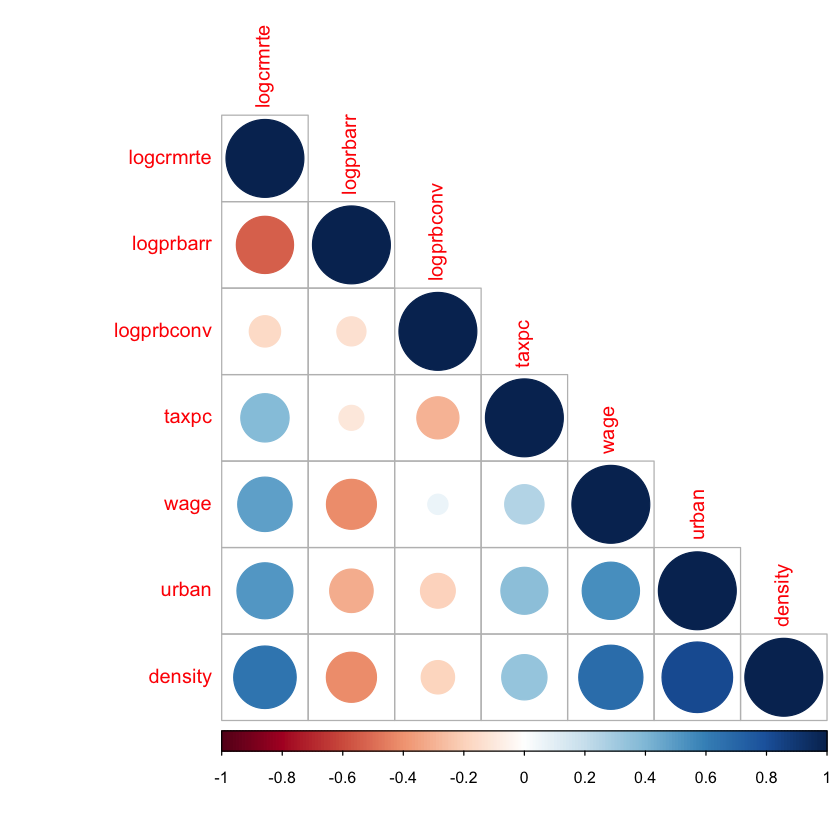

In [211]:
corrplot(cor(dfCrime[,c("logcrmrte", "logprbarr", "logprbconv","taxpc", "wage", "urban", "density")]),method='circle', type = 'lower')


In [193]:
#mod1 using logprbarr and logprbconv separately
mod1 <- lm(logcrmrte ~ logprbarr + logprbconv + density + taxpc, data = dfCrime)
mod1

summary(mod1)

#residuals: difference between the actual 
#observed resposne values (crmrate to crmjustice + taxpc)
#and the respionse values that the model predicted



Call:
lm(formula = logcrmrte ~ logprbarr + logprbconv + density + taxpc, 
    data = dfCrime)

Coefficients:
(Intercept)    logprbarr   logprbconv      density        taxpc  
  -2.019214    -0.492363    -0.095962     0.058127     0.003021  



Call:
lm(formula = logcrmrte ~ logprbarr + logprbconv + density + taxpc, 
    data = dfCrime)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40748 -0.07056  0.01227  0.08305  0.33304 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.019214   0.087448 -23.090  < 2e-16 ***
logprbarr   -0.492363   0.120576  -4.083  0.00011 ***
logprbconv  -0.095962   0.098790  -0.971  0.33449    
density      0.058127   0.012761   4.555 1.99e-05 ***
taxpc        0.003021   0.001413   2.138  0.03582 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1523 on 75 degrees of freedom
Multiple R-squared:  0.547,	Adjusted R-squared:  0.5228 
F-statistic: 22.64 on 4 and 75 DF,  p-value: 2.74e-12


In [212]:
# model 1b...using logprbcrmjustice
mod1b <- lm(logcrmrte ~ logprbcrmjustice + density + taxpc, data = dfCrime)
# mod1b
summary(mod1b)




Call:
lm(formula = logcrmrte ~ logprbcrmjustice + density + taxpc, 
    data = dfCrime)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41398 -0.05947  0.00282  0.10233  0.32570 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.926037   0.085230 -22.598  < 2e-16 ***
logprbcrmjustice -0.243350   0.088795  -2.741  0.00764 ** 
density           0.067273   0.012956   5.192 1.68e-06 ***
taxpc             0.002353   0.001461   1.610  0.11148    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1596 on 76 degrees of freedom
Multiple R-squared:  0.496,	Adjusted R-squared:  0.4762 
F-statistic: 24.94 on 3 and 76 DF,  p-value: 2.459e-11


## model 2

In [182]:
# list out high leverage points and rerun with 
# augment find broom package in tidy
# create new column for dummy variable 0,1 (maybe a package for this?)
# https://stats.idre.ucla.edu/r/modules/coding-for-categorical-variables-in-regression-models/
mod2 <- lm(dfCrime$crmrte ~ (dfCrime$prbconv + dfCrime$wcon*(1+dfCrime$urban)))
mod2
summary(mod2)


Call:
lm(formula = dfCrime$crmrte ~ (dfCrime$prbconv + dfCrime$wcon * 
    (1 + dfCrime$urban)))

Coefficients:
               (Intercept)             dfCrime$prbconv  
                 1.474e-02                  -1.404e-02  
              dfCrime$wcon               dfCrime$urban  
                 8.268e-05                   3.685e-02  
dfCrime$wcon:dfCrime$urban  
                -1.224e-05  



Call:
lm(formula = dfCrime$crmrte ~ (dfCrime$prbconv + dfCrime$wcon * 
    (1 + dfCrime$urban)))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.025235 -0.009620 -0.002084  0.005606  0.042781 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)   
(Intercept)                 1.474e-02  1.074e-02   1.373  0.17340   
dfCrime$prbconv            -1.404e-02  4.232e-03  -3.319  0.00133 **
dfCrime$wcon                8.268e-05  3.626e-05   2.280  0.02509 * 
dfCrime$urban               3.685e-02  2.692e-02   1.369  0.17459   
dfCrime$wcon:dfCrime$urban -1.224e-05  8.137e-05  -0.150  0.88075   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01383 on 85 degrees of freedom
Multiple R-squared:  0.4882,	Adjusted R-squared:  0.4641 
F-statistic: 20.27 on 4 and 85 DF,  p-value: 9.425e-12
